In [71]:
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import twitter_credentials

from tweepy import API
from tweepy import Cursor

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [63]:
from textblob import TextBlob
import re

In [51]:
class TwitterClient():
    def __init__(self, twitter_user = None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)
        
        self.twitter_user = twitter_user
        
    def get_twitter_client_api(self):
        return self.twitter_client
        
    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id = self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets
        
    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id = self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list
    
    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id = self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets

In [52]:
class TwitterAuthenticator():
    
    def authenticate_twitter_app(self):
        auth = OAuthHandler(twitter_credentials.consumer_key, twitter_credentials.consumer_secret)
        auth.set_access_token(twitter_credentials.access_token, twitter_credentials.access_token_secret)
        return auth

class TwitterStreamer():
    '''
    Class for streaming and processing live tweets.
    '''
    def __init__(self):
        self.twitter_authenticator = TwitterAuthenticator()
        
    def stream_tweets(self, fetched_tweets_filename, hash_tag_list, tweets_n):
        # This handles Twitter authentication and connection to the Twiiter Steaming API.
        l = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_authenticator.authenticate_twitter_app()
        stream = Stream(auth,l)
        
        stream.filter(track = hash_tag_list)

class TwitterListener(StreamListener):
    '''
    This is a basic listener class that just prints received tweets to stdout
    '''
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename
        
    def on_data(self,data):
        try:
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("Error on data: %s" % str(e))
        return True
    
    def on_error(self, status):
        if status == 420:
            # Returning False on data method in case rate limit occurs/
            return False
        print(status)



In [64]:
class TweetAnalyzer():
    '''
    Functionality for analyzing and categorizing content from tweets.
    '''
    
    def clean_tweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
    
    def analyze_sentiment(self, tweet):
        analysis = TextBlob(self.clean_tweet(tweet))
        
        if analysis.sentiment.polarity > 0:
            return 1
        if analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1
        
    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns = ['Tweets'])
        
        df['id'] = np.array([tweet.id for tweet in tweets])
        df['len'] = np.array([len(tweet.text) for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])
        
        return df


                                                Tweets                   id  \
150  Former President Barack Obama criticized the "...  1261766975879098370   
140  It's your night, class of 2020. https://t.co/4...  1261791054883360769   
87   Princeton University has named its first black...  1261990113602650112   
79   A new study — the largest of its kind — shows ...  1262020314822737920   
125  .@BillClinton to grads: "I know you've been de...  1261805415874035718   
149  Pygmy hippos are an endangered species, but in...  1261768909323210752   
109  Former President Barack Obama criticized the "...  1261857744837136391   
121  US Postal Service worker Josh Crowell lifts th...  1261817728274444290   
102  A pregnant woman traveling through India by fo...  1261899521916837894   
194  A new study — the largest of its kind — shows ...  1261657925354958850   

     len                date                source  likes  retweets  sentiment  
150  140 2020-05-16 21:14:24            SocialFlo

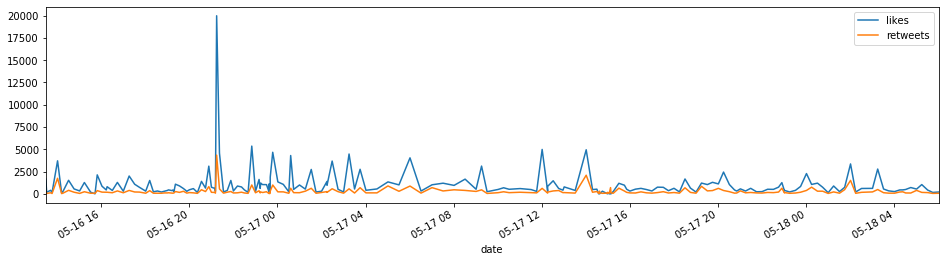

In [70]:
if __name__ == '__main__':
    
    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()
    api = twitter_client.get_twitter_client_api()
    
    tweets = api.user_timeline(screen_name = "CNN", count=200)
    
    df = tweet_analyzer.tweets_to_data_frame(tweets)
    df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['Tweets']])
    
    df1 = df.sort_values("likes",ascending=False)
    print(df1.head(10))

    # print(df.head(10))
    # Get average length over all tweets.
    print(np.mean(df['len']))
    
    # Get the number of likes for the most liked tweet.
    print(np.max(df['likes']))
    
    # Get the number of retweets for the most liked tweet.
    print(np.max(df['retweets']))
    
    # Time Series
    # time_likes = pd.Series(data=df['likes'].values, index = df['date'])
    # time_likes.plot(figsize=(16, 4), color='r')
    # plt.show()
    
    time_likes = pd.Series(data=df['likes'].values, index = df['date'])
    time_likes.plot(figsize=(16, 4), label="likes", legend=True)
    
    time_likes = pd.Series(data=df['retweets'].values, index = df['date'])
    time_likes.plot(figsize=(16, 4), label="retweets", legend=True)
    plt.show()
    

In [73]:
hash_tag_list = ['suicide']
fetched_tweets_filename = 'tweets.txt'
twitter_streamer = TwitterStreamer()
twitter_streamer.stream_tweets(fetched_tweets_filename, hash_tag_list)

{"created_at":"Mon May 18 20:27:29 +0000 2020","id":1262479947366531072,"id_str":"1262479947366531072","text":"RT @CP24: Taliban suicide bomber kills 9 troops in eastern Afghanistan https:\/\/t.co\/tKyeefrYib https:\/\/t.co\/5DX2FAOvoc","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":170050390,"id_str":"170050390","name":"\u2661\u2661\u2661","screen_name":"sincerelyzohal","location":"Toronto, Ontario","url":null,"description":"\u201c\ud83d\ude1b\u201d is my fav emoji","translator_type":"none","protected":false,"verified":false,"followers_count":244,"friends_count":271,"listed_count":0,"favourites_count":4080,"statuses_count":26221,"created_at":"Fri Jul 23 20:36:57 +0000 2010","utc_offset":null,"time_zone":null,"geo_enabled":false,"la

{"created_at":"Mon May 18 20:27:32 +0000 2020","id":1262479957416120322,"id_str":"1262479957416120322","text":"@faIIingari @gngaris He is not. I think you\u2019re forgetting about logan paul filming a dead man after he had just com\u2026 https:\/\/t.co\/5wOVTe4Cko","display_text_range":[21,140],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":1262479410499923969,"in_reply_to_status_id_str":"1262479410499923969","in_reply_to_user_id":182031396,"in_reply_to_user_id_str":"182031396","in_reply_to_screen_name":"faIIingari","user":{"id":411986642,"id_str":"411986642","name":"liv","screen_name":"everglowari","location":"elias","url":null,"description":"abel tesfaye","translator_type":"none","protected":false,"verified":false,"followers_count":1620,"friends_count":381,"listed_count":37,"favourites_count":48989,"statuses_count":13127,"created_at":"Mon Nov 14 03:59:41 +0000 2011","u

{"created_at":"Mon May 18 20:27:34 +0000 2020","id":1262479967767625728,"id_str":"1262479967767625728","text":"RT @ilovetopiss: if i was a character on the joker movie my name would be \"Barbwire Suicide\"","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":2837846002,"id_str":"2837846002","name":"Deviant Thoughts","screen_name":"StringTheory420","location":null,"url":null,"description":"computer virus","translator_type":"none","protected":false,"verified":false,"followers_count":92,"friends_count":145,"listed_count":3,"favourites_count":45121,"statuses_count":5179,"created_at":"Mon Oct 20 02:16:21 +0000 2014","utc_offset":null,"time_zone":null,"geo_enabled":true,"lang":null,"contributors_enabled":false,"is_translator":false,"profile_ba

{"created_at":"Mon May 18 20:27:35 +0000 2020","id":1262479970196168704,"id_str":"1262479970196168704","text":"RT @OgbeniDipo: NIPOST should not be allowed to charge these ridiculous fees, @MBuhari, @ProfOsinbajo. Thousands of young Nigerians have lo\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1872646490,"id_str":"1872646490","name":"OMORAPALA","screen_name":"ilesanmi_mayowa","location":"lagos","url":"http:\/\/instagram.com\/secret_affairs_","description":"just one happy guy !! I run an online business where i sell everything underwear and lingerie , a serious \ud83e\udd21 you can check my ig : @sercret_affairs_","translator_type":"none","protected":false,"verified":false,"followers_count":1346,"friends_count":1069,"listed

{"created_at":"Mon May 18 20:27:36 +0000 2020","id":1262479974642208768,"id_str":"1262479974642208768","text":"RT @DFBHarvard: Blue State Governors are demanding small business owners commit financial suicide!\n\nStay Shut Down or we'll shutter you dow\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":794618843364753409,"id_str":"794618843364753409","name":"Regina","screen_name":"ReginaMcCarth19","location":"Westlake, Ohio, USA","url":null,"description":"Me and a little lamb in Jerusalem. Inspiring trip. Marched for Trump in DC (his hotel above) in 2018, will do so again in 2020. MAGA. Let\u2019s vote out Dems.","translator_type":"none","protected":false,"verified":false,"followers_count":397,"friends_count":590,"listed_count":0

{"created_at":"Mon May 18 20:27:37 +0000 2020","id":1262479979729891328,"id_str":"1262479979729891328","text":"Will y'all stop trolling now when the person you are trolling is contemplating suicide?\n\nThe love for drama and unn\u2026 https:\/\/t.co\/aS3GofUIyX","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":44859004,"id_str":"44859004","name":"Sanitarian Temitope Agboola\u2122","screen_name":"topgee992","location":"Heaven","url":null,"description":"Just a cool badu sharpu guyz.... Arsenal rocks! Environmental Health Scientist. Snapchat: topgee992","translator_type":"none","protected":false,"verified":false,"followers_count":15418,"friends_count":7468,"listed_count":38,"favourites_count":1121,"statuses_count":201661,"created_at":"Fri Jun 05 09:42

{"created_at":"Mon May 18 20:27:39 +0000 2020","id":1262479988718067712,"id_str":"1262479988718067712","text":"RT @CharlieDaniels: 22 VETERANS COMMIT SUICIDE EVERY DAY!","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1328461706,"id_str":"1328461706","name":"Jonathan \u2b50\u2b50\u2b50","screen_name":"JonGordon49","location":null,"url":null,"description":"Married with two kids. #electrician #Trump #prolife #vet #2a #1a #God  #America #MAGA #KAG \ud83d\udc49not pc","translator_type":"none","protected":false,"verified":false,"followers_count":3206,"friends_count":4446,"listed_count":26,"favourites_count":27604,"statuses_count":61020,"created_at":"Fri Apr 05 05:35:54 +0000 2013","utc_offset":null,"time_zone":null,"geo_enabled":true,"l

{"created_at":"Mon May 18 20:27:43 +0000 2020","id":1262480003545079811,"id_str":"1262480003545079811","text":"RT @lipiroy: Physician #burnout &amp; #suicide were epidemics BEFORE this pandemic. How can we stem the tide to prevent the #COVID19 crisis fro\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1234867489802215425,"id_str":"1234867489802215425","name":"Jacob","screen_name":"Jacob13867464","location":null,"url":null,"description":"rie y el mundo reira contigo llora y lloraras solo","translator_type":"none","protected":false,"verified":false,"followers_count":42,"friends_count":26,"listed_count":0,"favourites_count":4790,"statuses_count":5241,"created_at":"Tue Mar 03 15:45:44 +0000 2020","utc_offset":null,"time_zone":nu

{"created_at":"Mon May 18 20:27:47 +0000 2020","id":1262480019533606913,"id_str":"1262480019533606913","text":"RT @Nikki_Trw: SUICIDE HOTLINE.\n\nUnited Kingdom \ud83c\uddec\ud83c\udde7 116 123\nUnited States \ud83c\uddfa\ud83c\uddf8 1-800-273-8255\nCanada \ud83c\udde8\ud83c\udde6 1 800 456 4566\nIreland \ud83c\uddee\ud83c\uddea 116 123\nPhil\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":783469490,"id_str":"783469490","name":"Glenda\u262e\u2764\ud83e\uddd8\u200d\u2640\ufe0f","screen_name":"glenda_aus","location":"World citizen","url":null,"description":"Music lover (alternative, 70's). Still alive and kicking, and will continue to, till I don't. Optimist. #resist #knitting #cannibis","translator_type":"none","protected":fals

{"created_at":"Mon May 18 20:27:51 +0000 2020","id":1262480038907297792,"id_str":"1262480038907297792","text":"Delete kya kiya wo important suicide Nhi \ud83d\ude02 https:\/\/t.co\/Kygcqp9fLQ","display_text_range":[0,42],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":949978541952782336,"id_str":"949978541952782336","name":"Abeera Sheikh\u2764","screen_name":"AbeeraSheikh15","location":"Home Sweet Home ","url":"https:\/\/twitter.com\/search\/from:@AbeeraSheikh15$-filter:mentions","description":"No love is greater than mom's love. No care  is greater than dad's care.\nA daughter, A Sister and A  Friend.","translator_type":"none","protected":false,"verified":false,"followers_count":27865,"friends_count":105,"listed_count":0,"favourit

{"created_at":"Mon May 18 20:27:52 +0000 2020","id":1262480041704697858,"id_str":"1262480041704697858","text":"\u201cYoung spent many days attending traditional ceremonies &amp; playing outside under the stars alongside her younger bro\u2026 https:\/\/t.co\/sYG2I180BV","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1247220035959115778,"id_str":"1247220035959115778","name":"Protect the Sacred","screen_name":"protect_sacred","location":"Navajo Nation","url":"http:\/\/protectthesacred.net","description":"Grassroots initiative created by Navajo organizers to protect what\u2019s sacred to our people - our elders, language, medicine ways, & culture - from #COVID19","translator_type":"none","protected":false,"verified":false,"followers_coun

{"created_at":"Mon May 18 20:27:55 +0000 2020","id":1262480053864140802,"id_str":"1262480053864140802","text":"BEM ASSIM MSM KKKKKKK https:\/\/t.co\/mPZHRi7ovl","display_text_range":[0,21],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":863408845527420928,"id_str":"863408845527420928","name":"\u03b1\u027el\u04bd\u0566\u0574\u00ed\u0572\u03b1 SiNcErA t\u00e1 de metadinha","screen_name":"miss_nothingO1","location":"Birds Of Prey","url":"http:\/\/aminoapps.com\/p\/nxizr9","description":"\u2756fangirl fudida da arlequina, obcecada pelo Eminem best @sjjssiekks \u2764\ufe0f RT ou like em tweets que me indentifico ou pk gostei agr cai fora\u2756 @Jester_LaughO1 rp","translator_type":"none","protected":false,"verified":false,"followers_cou

{"created_at":"Mon May 18 20:27:57 +0000 2020","id":1262480062399631361,"id_str":"1262480062399631361","text":"A 13-year-old Junior Secondary School 2 pupil, Josephine Wonah, has allegedly committed suicide.\n\nThe incident happ\u2026 https:\/\/t.co\/9fZHGsPtSn","display_text_range":[0,140],"source":"\u003ca href=\"https:\/\/www.blog2social.com\" rel=\"nofollow\"\u003eBlog2Social APP\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1257036857684250629,"id_str":"1257036857684250629","name":"Sisi-PortHarcourt","screen_name":"PhcSisi","location":null,"url":null,"description":"Sisi Port Harcourt is a community watchdog reporting on life, building resilient communities, untold\/under reported stories and much more.","translator_type":"none","protected":false,"verified":false,"followers_count":3,"friends_count":18,"listed_count":0,"favourites_cou

{"created_at":"Mon May 18 20:28:00 +0000 2020","id":1262480077801037836,"id_str":"1262480077801037836","text":"RT @LionelMedia: Of course not. That would only make sense. That would only rekindle and reaffirm your faith in the system. That would only\u2026","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1183737961646579713,"id_str":"1183737961646579713","name":"MLG","screen_name":"MLG09217249","location":"NW Georgia","url":null,"description":"Jesus redeemed me. I'm grateful.  Educator and Musician. Enjoy life! Retired. Husband, father of 3 sons, grandfather of 10. MAGA. Q.   RT is not an endorsement.","translator_type":"none","protected":false,"verified":false,"followers_count":810,"friends_count":1844,"listed_count":0,"favourites_count":9335,"s

{"created_at":"Mon May 18 20:28:02 +0000 2020","id":1262480085250183172,"id_str":"1262480085250183172","text":"RT @TheNationNews: A 13 year-old girl has reportedly committed suicide in Warri, Delta state over beatings she received for engaging in sex\u2026","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":564398309,"id_str":"564398309","name":"Bourgeoisie (Engr.)","screen_name":"wonowan","location":"South South, Nigeria","url":null,"description":"Humanist.\nPetrochemical Engineer.\n#ArsenalFC.\n\nMy life is a struggle between; my need for acceptance, my fear of rejection, and a desire not to care at all.","translator_type":"none","protected":false,"verified":false,"followers_count":1147,"friends_count":1044,"listed_count":10,"favourites_count":385

{"created_at":"Mon May 18 20:28:04 +0000 2020","id":1262480093466820611,"id_str":"1262480093466820611","text":"Baggaji! \u0905\u092c \u0906\u092a\u0915\u094b suicide \u0915\u0930 \u0932\u0947\u0928\u0940 \u091a\u093e\u0939\u093f\u090f ? \u0906\u092a\u0915\u0940 \u092a\u093e\u0930\u094d\u091f\u0940 \u092e\u0948\u0902 \u0905\u092c \u0939\u093f\u091c\u0921\u093c\u094b\u0902 \u0915\u0940 \u092b\u093c\u094c\u091c \u0907\u0915\u091f\u094d\u0920\u0940 \u0939\u094b \u0917\u0908 \u0939\u0948 \u091c\u094b \u092f\u0947 \u0938\u092c \u0926\u0947\u0916\u0915\u0930 \u092d\u0940 \u0915\u0941\u091b \u0928\u2026 https:\/\/t.co\/V8xZhb1hfC","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":4823653097,"id_str":"4823653097","name":"ShadowCabinet","screen_n

{"created_at":"Mon May 18 20:28:05 +0000 2020","id":1262480098864791555,"id_str":"1262480098864791555","text":"BIRTH\n\nI've always wanted Jared &amp; Shannon to write that lyric \n\ud83c\udfb6i will save you from yourself\ud83c\udfb6 \nto get tattooed bec\u2026 https:\/\/t.co\/bgxqeP8VYE","display_text_range":[0,140],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":957286629647048704,"id_str":"957286629647048704","name":"Crippledplaything66","screen_name":"Jane_ModernMyth","location":null,"url":null,"description":null,"translator_type":"none","protected":false,"verified":false,"followers_count":343,"friends_count":553,"listed_count":0,"favourites_count":12584,"statuses_count":8181,"created_at":"Sat Jan 27 16:18:12 +0000 2018","utc_off

{"created_at":"Mon May 18 20:28:06 +0000 2020","id":1262480102388088835,"id_str":"1262480102388088835","text":"RT @thatbennybee: If you think it's funny to make fun of trans suicide rates please unfollow me.\n\nThat's not funny. Idc whether you're tran\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1246693370002583552,"id_str":"1246693370002583552","name":"\u26d3\ufe0fSapphire Sapphic\u26d3\ufe0f","screen_name":"Sapphy_Sapphy","location":"she\/her","url":null,"description":"\ud83d\udc99\ud83d\udc96\u26aa\ud83d\udc96\ud83d\udc99\ud83d\udd1e minors dni \/ 18, sub, lesbian, not cis \/ horny account \/ the safeword is sunstone \/  fighting is useless \/ be gay do crime \/ owned by @peen_gorl \/","translator_type":"none","protec

{"created_at":"Mon May 18 20:28:10 +0000 2020","id":1262480117609234432,"id_str":"1262480117609234432","text":"Euthanasia and suicide are illegal. If he was going to shoot a gun out towards a street, not aiming at anyone in pa\u2026 https:\/\/t.co\/WZ19dx8o2l","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":976650784099061760,"id_str":"976650784099061760","name":"MourningInAmerica","screen_name":"parr_yes","location":"NY Tough, NYSmart, NYLoving","url":null,"description":"Fighting the good fight, creating great art, Mom, wife and former civil servant","translator_type":"none","protected":false,"verified":false,"followers_count":120,"friends_count":264,"listed_count":0,"favourites_count":6219,"statuses_count":4550,"created_at":"Thu Mar 22 02:44:27 

{"created_at":"Mon May 18 20:28:13 +0000 2020","id":1262480129491718144,"id_str":"1262480129491718144","text":"@BloxUKPM @BloxSPresident Oh god  I just saw this, suicide should not be tolerated anywhere on the platform, and no\u2026 https:\/\/t.co\/uNYN13B3d9","display_text_range":[26,140],"source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":1262417934682599425,"in_reply_to_status_id_str":"1262417934682599425","in_reply_to_user_id":1045994302336364544,"in_reply_to_user_id_str":"1045994302336364544","in_reply_to_screen_name":"BloxUKPM","user":{"id":1258184053435629570,"id_str":"1258184053435629570","name":"Meo Woods","screen_name":"MeoWoods","location":"Canada, Bloxburg","url":null,"description":"I am the Minister of State for Public Safety and Emergency Preparedness for Canada and WHO Chief Press Secretary.","translator_type":"none","protected":false,"verified":false,"followers_count":22,"

{"created_at":"Mon May 18 20:28:14 +0000 2020","id":1262480136043212800,"id_str":"1262480136043212800","text":"RT @_Sofiane_: Subhan'Allah... j'ai re\u00e7u environ 300 DM, des invocations \u00e0 r\u00e9citer, des conseils, des messages de soutien alors que je voul\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":4365366557,"id_str":"4365366557","name":"Kaoutare","screen_name":"ktr_gf","location":"ici","url":null,"description":"\ud83c\uddf2\ud83c\udde6","translator_type":"none","protected":false,"verified":false,"followers_count":146,"friends_count":147,"listed_count":3,"favourites_count":1911,"statuses_count":11644,"created_at":"Thu Dec 03 21:44:11 +0000 2015","utc_offset":null,"time_zone":null,"geo_enabled":false,"lang":nul

{"created_at":"Mon May 18 20:28:15 +0000 2020","id":1262480138199011334,"id_str":"1262480138199011334","text":"RT @IndigoBlxe: Hey guys! @LordLampington and I are hosting an anime night in my Party Night discord at 8pm EST! We're gonna be watching De\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1163209595806003200,"id_str":"1163209595806003200","name":"Lord Lampington","screen_name":"LordLampington","location":null,"url":"https:\/\/www.youtube.com\/channel\/UC-1PRMrj4jdKRdTs0TGapFg","description":"A living, emotionally unstable vibe check\n\npfp by: @Luna_pupper","translator_type":"none","protected":false,"verified":false,"followers_count":234,"friends_count":154,"listed_count":3,"favourites_count":32077,"statuses_count":

{"created_at":"Mon May 18 20:28:22 +0000 2020","id":1262480168549076993,"id_str":"1262480168549076993","text":"@Msdmurph @thehill It sounds more like a @RNC #COVID19 suicide pact.\nDeath by stupidity.","display_text_range":[19,88],"source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":1262477853272260608,"in_reply_to_status_id_str":"1262477853272260608","in_reply_to_user_id":455394628,"in_reply_to_user_id_str":"455394628","in_reply_to_screen_name":"Msdmurph","user":{"id":773954934345719809,"id_str":"773954934345719809","name":"BubbaWubba","screen_name":"bubba_wubba","location":null,"url":null,"description":null,"translator_type":"none","protected":false,"verified":false,"followers_count":1083,"friends_count":1775,"listed_count":8,"favourites_count":56216,"statuses_count":72360,"created_at":"Thu Sep 08 18:43:30 +0000 2016","utc_offset":null,"time_zone":null,"geo_enabled":true,"lang":null,"co

{"created_at":"Mon May 18 20:28:25 +0000 2020","id":1262480180112752641,"id_str":"1262480180112752641","text":"@realDonaldTrump @washingtonpost poor central control, nothing on hand to ship, people suffering &amp; dying, finally s\u2026 https:\/\/t.co\/o97GajD2lj","display_text_range":[33,140],"source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":1262478378109673473,"in_reply_to_status_id_str":"1262478378109673473","in_reply_to_user_id":1186663536124157954,"in_reply_to_user_id_str":"1186663536124157954","in_reply_to_screen_name":"ArmesHarry","user":{"id":1186663536124157954,"id_str":"1186663536124157954","name":"harry armes","screen_name":"ArmesHarry","location":"NY","url":null,"description":"Working to remove the infection known as the Republican Party from elected office everywhere...","translator_type":"none","protected":false,"verified":false,"followers_count":18,"friends_count":125,"li

{"created_at":"Mon May 18 20:28:28 +0000 2020","id":1262480192729014272,"id_str":"1262480192729014272","text":"RT @Liz_Wheeler: \u201cUpdated infection fatality rates (IFR) are less than or equal to seasonal flu for those under 60 in France, Spain and the\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1015672744174706688,"id_str":"1015672744174706688","name":"Sally","screen_name":"Sally01492597","location":null,"url":null,"description":"Mother, Ceramic Artist, Entrepreneur, LEGAL immigrant #MAGA #TRUMP2020 #POTUS #PROLIFE #TRUMP45 #DRAINTHESWAMP","translator_type":"none","protected":false,"verified":false,"followers_count":619,"friends_count":1529,"listed_count":0,"favourites_count":12289,"statuses_count":12139,"created_at":"

{"created_at":"Mon May 18 20:28:33 +0000 2020","id":1262480214686224385,"id_str":"1262480214686224385","text":"Adding to Dr. Fauci's diagnosis: The critical case for ending our shutdown | TheHill https:\/\/t.co\/bIpQTN1TRG","source":"\u003ca href=\"http:\/\/twitter.com\/#!\/download\/ipad\" rel=\"nofollow\"\u003eTwitter for iPad\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1202306455560323072,"id_str":"1202306455560323072","name":"OldManTakeALookAtMyLife","screen_name":"old_take","location":null,"url":null,"description":"Leftism Delenda Est because Inside Every \u201cProgressive\u201d Is A Totalitarian Screaming To Get Out and enslave us","translator_type":"none","protected":false,"verified":false,"followers_count":1087,"friends_count":1929,"listed_count":1,"favourites_count":58376,"statuses_count":39452,"created_at":"Wed Dec 04 19:20:

{"created_at":"Mon May 18 20:28:34 +0000 2020","id":1262480218461057030,"id_str":"1262480218461057030","text":"RT @KashJackson2018: Its not often I encounter a Democratic candidate that will make references to a veteran about hanging themselves with\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":35215486,"id_str":"35215486","name":"Cindy Woods","screen_name":"wolf1u2","location":"Washington, USA","url":null,"description":"Imperfect Christ follower, proud American. Believe we are all simply 1 Race, the Human Race! America, love it or leave it! Just sayin!!","translator_type":"none","protected":false,"verified":false,"followers_count":4049,"friends_count":3961,"listed_count":30,"favourites_count":86897,"statuses_count":139533

{"created_at":"Mon May 18 20:28:35 +0000 2020","id":1262480221296627714,"id_str":"1262480221296627714","text":"@YvanShicolito @LennyTheGreat_ @AerisX_ @KEEMSTAR Mate, you could suicide in the bath lmao. I don't think his girlf\u2026 https:\/\/t.co\/yDxHODnWIB","display_text_range":[50,140],"source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":1262479458096877578,"in_reply_to_status_id_str":"1262479458096877578","in_reply_to_user_id":730939665436528640,"in_reply_to_user_id_str":"730939665436528640","in_reply_to_screen_name":"YvanShicolito","user":{"id":1231319634336452608,"id_str":"1231319634336452608","name":"Zeelas","screen_name":"Zeelas1","location":null,"url":null,"description":null,"translator_type":"none","protected":false,"verified":false,"followers_count":0,"friends_count":2,"listed_count":0,"favourites_count":0,"statuses_count":9,"created_at":"Sat Feb 22 20:47:39 +0000 2020","utc_of

{"created_at":"Mon May 18 20:28:37 +0000 2020","id":1262480229769064448,"id_str":"1262480229769064448","text":"RT @RadioFreeTom: Meanwhile, poor white people are still poor and white, and looked down upon by the elites more than they ever were; their\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":51448565,"id_str":"51448565","name":"Kevin Beswick","screen_name":"PPTPhoto","location":"USA","url":null,"description":"Small Business Creatives providing HD Hotel Photography to leading Hotel Brands throughout the USA since 1991.","translator_type":"none","protected":false,"verified":false,"followers_count":1057,"friends_count":5001,"listed_count":70,"favourites_count":12177,"statuses_count":11451,"created_at":"Sat Jun 27 14:16:26 +

{"created_at":"Mon May 18 20:28:39 +0000 2020","id":1262480240565260289,"id_str":"1262480240565260289","text":"RT @oflynnsocial: This was just one of our broadcast political media's post-referendum crushes. Others were Rory Stewart, People's Vote and\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":350205515,"id_str":"350205515","name":"Adrian Foster","screen_name":"fbear999","location":"Sandy, Bedfordshire, UK.","url":null,"description":"Politically light Blue. Semi retired.  Hoping  for a good  deal on Brexit. Celebrating a great result for British democracy. Want more money for Public services","translator_type":"none","protected":false,"verified":false,"followers_count":336,"friends_count":347,"listed_count":3,"favourites

{"created_at":"Mon May 18 20:28:40 +0000 2020","id":1262480245560684545,"id_str":"1262480245560684545","text":"@_seench Suicide toi wlh c foutu la v\u00e9rit\u00e9 sort de la bouche des enfants","display_text_range":[9,72],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":1262352443230367745,"in_reply_to_status_id_str":"1262352443230367745","in_reply_to_user_id":1249842210515881985,"in_reply_to_user_id_str":"1249842210515881985","in_reply_to_screen_name":"_seench","user":{"id":1158929791841685504,"id_str":"1158929791841685504","name":"nadjibo13015","screen_name":"nadjibo13015","location":"Marseille, France","url":null,"description":null,"translator_type":"none","protected":false,"verified":false,"followers_count":19,"friends_count":15,"listed_count":0,"favourites_count":265,"statuses_count":259,"created_at":"Wed Aug 07 02:36:09 +0000 2019","utc_offset":null,"time_zone":nul

{"created_at":"Mon May 18 20:28:48 +0000 2020","id":1262480277181530112,"id_str":"1262480277181530112","text":"@PodcastATI Do you think in Quarantine if we didn\u2019t have technology all of us could be \u201dSocial Suicide\u201d because we\u2026 https:\/\/t.co\/du6SkDAeBT","display_text_range":[12,140],"source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":1262143556405407748,"in_reply_to_status_id_str":"1262143556405407748","in_reply_to_user_id":948066566561603584,"in_reply_to_user_id_str":"948066566561603584","in_reply_to_screen_name":"PodcastATI","user":{"id":1154023095096811520,"id_str":"1154023095096811520","name":"Abey Gamer Lil","screen_name":"AbeyLil","location":null,"url":null,"description":null,"translator_type":"none","protected":false,"verified":false,"followers_count":0,"friends_count":13,"listed_count":0,"favourites_count":2,"statuses_count":3,"created_at":"Wed Jul 24 13:38:41

{"created_at":"Mon May 18 20:28:49 +0000 2020","id":1262480282453782531,"id_str":"1262480282453782531","text":"RT @HoodieCurry: Faking a suicide attempt for some clout? Y\u2019all don\u2019t realize what people really deal with and go through","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1155894798169051137,"id_str":"1155894798169051137","name":"\u2076\ud80c\udd53","screen_name":"KNICKSxMETS","location":"Bronx, NY","url":null,"description":"death to a coward and a traitor, that\u2019s just in my nature. @Zendaya \ud83d\udda4 #NewYorkForever","translator_type":"none","protected":false,"verified":false,"followers_count":470,"friends_count":1249,"listed_count":0,"favourites_count":16353,"statuses_count":11134,"created_at":"Mon Jul 29

{"created_at":"Mon May 18 20:28:58 +0000 2020","id":1262480317639569412,"id_str":"1262480317639569412","text":"@jennifermuro @JamesGunn Can we get some news about suicide squad atleast.. Havn't heard from you.. How passionate are you with this movie..","display_text_range":[25,140],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":1262467179494076417,"in_reply_to_status_id_str":"1262467179494076417","in_reply_to_user_id":37007382,"in_reply_to_user_id_str":"37007382","in_reply_to_screen_name":"jennifermuro","user":{"id":1201797422193627136,"id_str":"1201797422193627136","name":"TheArjunLoveable","screen_name":"AArjunLoveable","location":null,"url":null,"description":"Hero for fun \ud83d\udcaa","translator_type":"none","protected":false,"verified":false,"followers_count":23,"friends_count":307,"listed_count":0,"favourites_count":5916,"statuses_count":1370,"created_at":"Tue

{"created_at":"Mon May 18 20:29:00 +0000 2020","id":1262480325579399168,"id_str":"1262480325579399168","text":"@romanopiumtales @mistergoodgod For years we have had a high suicide count in NZ\n\nTop 4th country for male suicides\u2026 https:\/\/t.co\/iEQiqXQHP6","display_text_range":[32,140],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":1262438350075555841,"in_reply_to_status_id_str":"1262438350075555841","in_reply_to_user_id":54372215,"in_reply_to_user_id_str":"54372215","in_reply_to_screen_name":"romanopiumtales","user":{"id":1207205162047033344,"id_str":"1207205162047033344","name":"Te Kerer\u016b","screen_name":"SGSMITH_","location":"New Zealand","url":"http:\/\/gumroad.com\/l\/OVgae\/free","description":"Speculative Fiction Writer\/ Living on the edge of a Super-Volcano \/ TE KERER\u016a BK 1 - THE NEST is out! http:\/\/gumroad.com\/l\/tekereru1 \/ 3 chapters for F

{"created_at":"Mon May 18 20:29:04 +0000 2020","id":1262480345376501761,"id_str":"1262480345376501761","text":"RT @LovelyFilters: love is the most popular form of suicide but i prefer trying to catch a comet with my hands","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":2484986059,"id_str":"2484986059","name":"malik durafshan","screen_name":"malik_durafshan","location":"anantnag","url":null,"description":"I will not compromise myself - I am all I have.","translator_type":"none","protected":false,"verified":false,"followers_count":67,"friends_count":99,"listed_count":0,"favourites_count":1208,"statuses_count":218,"created_at":"Fri May 09 07:21:27 +0000 2014","utc_offset":null,"time_zone":null,"geo_enabled":false,"lang":null,"contributors_enabled":

{"created_at":"Mon May 18 20:29:06 +0000 2020","id":1262480353807269888,"id_str":"1262480353807269888","text":"asuka \/\/ asuka hehehehehe https:\/\/t.co\/WhSoNWDAjE","display_text_range":[0,25],"source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1166875614051262464,"id_str":"1166875614051262464","name":"\u2606.\uff9f\uff61 \u1d20\u026a\u1d00\u1d05\u1d0f \u1d0d\u1d00\u1d0b\u1d0f\u0274\u029c\u1d00 \uff61.\uff9f\u2606","screen_name":"AKlHlKOkaji","location":".\u2022  EVA 00  \u2022.   pt | en | fr","url":null,"description":"given stan  \u2022  she | her","translator_type":"none","protected":false,"verified":false,"followers_count":329,"friends_count":350,"listed_count":0,"favourites_count":6226,"statuses_count":2566,"created_at":"Thu Aug 29 00:50:11 +0

{"created_at":"Mon May 18 20:29:07 +0000 2020","id":1262480357003276295,"id_str":"1262480357003276295","text":"@cooljesuis Surtout qu\u2019on fait en plus en ce moment une enoooorme publicit\u00e9 pour limiter il faut le dire le nombre\u2026 https:\/\/t.co\/fhG12Hu3mq","display_text_range":[12,140],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":1262480006527291394,"in_reply_to_status_id_str":"1262480006527291394","in_reply_to_user_id":714693932,"in_reply_to_user_id_str":"714693932","in_reply_to_screen_name":"44jacko","user":{"id":714693932,"id_str":"714693932","name":"oui","screen_name":"44jacko","location":"N\u00eemes, France","url":null,"description":"ce qui rend fou l\u2019homme ce n\u2019est pas le doute mais la certitude","translator_type":"none","protected":false,"verified":false,"followers_count":105,"friends_count":226,"listed_count":2,"favourites_count":575,"sta

{"created_at":"Mon May 18 20:29:10 +0000 2020","id":1262480369896620033,"id_str":"1262480369896620033","text":"RT @RealJamesWoods: \u201cSo far, no spike in coronavirus in places reopening, U.S. health secretary says.\u201d \/\/ Nancy Pelosi gets nightmares read\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":211068552,"id_str":"211068552","name":"\ud83d\udc9eCindy Kennedy\u2b50\ud83c\uddfa\ud83c\uddf8","screen_name":"CIndyStarbuck","location":null,"url":null,"description":"#MAGA #TRUMP SUPPORTERS WE TOOK BACK #USA FOR OUR FAMILIES FUTURE. TRADITIONAL MARRIAGE IS GODS CREATION \/ #GOD BLESS AMERICA \/ GOD BLESS PRESIDENT TRUMP\ud83d\ude9d","translator_type":"none","protected":false,"verified":false,"followers_count":12454,"f

{"created_at":"Mon May 18 20:29:11 +0000 2020","id":1262480373830819852,"id_str":"1262480373830819852","text":"@lathamphil1 @dangerousmojito @pritipatel Yes and the best talent will be flocking in to a country which is about t\u2026 https:\/\/t.co\/XUEkvlWaYG","display_text_range":[42,140],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":1262472124360507398,"in_reply_to_status_id_str":"1262472124360507398","in_reply_to_user_id":2603704105,"in_reply_to_user_id_str":"2603704105","in_reply_to_screen_name":"lathamphil1","user":{"id":1121518734424858624,"id_str":"1121518734424858624","name":"Need a break","screen_name":"Needabreak10","location":null,"url":null,"description":null,"translator_type":"none","protected":false,"verified":false,"followers_count":32,"friends_count":67,"listed_count":0,"favourites_count":17948,"statuses_count":16890,"created_at":"Thu Apr 25 20:57:57 +

{"created_at":"Mon May 18 20:29:13 +0000 2020","id":1262480383385366528,"id_str":"1262480383385366528","text":"RT @HoodHealer: We\u2019ve heard a lot about death by covid-19 but the numbers we should be paying attention to are the increasing numbers of de\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":3042669205,"id_str":"3042669205","name":"\ud83d\udcb6","screen_name":"aircuhhh","location":null,"url":null,"description":"LA.","translator_type":"none","protected":false,"verified":false,"followers_count":2778,"friends_count":1304,"listed_count":4,"favourites_count":109356,"statuses_count":69768,"created_at":"Thu Feb 26 06:32:26 +0000 2015","utc_offset":null,"time_zone":null,"geo_enabled":true,"lang":null,"contributors_enabled":

{"created_at":"Mon May 18 20:29:16 +0000 2020","id":1262480394093342722,"id_str":"1262480394093342722","text":"RT @UmadeItOK: @andyinTOONT @senatemajldr @AmyMcGrathKY #MoscowMitch cares his much he can put in his own pockets. Kentucky, be damned! I a\u2026","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":3174609447,"id_str":"3174609447","name":"Peggy Aronowitz","screen_name":"peggy_aronowitz","location":"Arizona","url":null,"description":"Educator:critical thinking matters. Mom,wife, love animals,poetry, flowers, bicycling, hiking. Forest Service & library volunteer. #RESIST #VoteBlue #FBR","translator_type":"none","protected":false,"verified":false,"followers_count":3739,"friends_count":4986,"listed_count":2,"favourites_count":49097,"statuses_co

{"created_at":"Mon May 18 20:29:23 +0000 2020","id":1262480423571075072,"id_str":"1262480423571075072","text":"Americans like the ones in Bengazi deserved to live but did you give a shit? Hell No! You lost for a reason you lie\u2026 https:\/\/t.co\/e4rce4RZF2","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":2461207581,"id_str":"2461207581","name":"Gary. \ud83c\uddfa\ud83c\uddf8 MAGA \ud83c\uddfa\ud83c\uddf8 USA 2020","screen_name":"toolsdude65","location":"New Jersey, USA","url":null,"description":"Living the Dream, devoted family Guy, Proud American and Patriot. #MAGA\n#KAG2020 #Muchlove #Bordeauxbrosnj","translator_type":"none","protected":false,"verified":false,"followers_count":11209,"friends_count":10984,"listed_count":5,"favou

{"created_at":"Mon May 18 20:29:25 +0000 2020","id":1262480433729679361,"id_str":"1262480433729679361","text":"I post this every year but talking about suicide \/ mental health is as important as ever at the moment. It\u2019ll be 10\u2026 https:\/\/t.co\/4nECtxykXw","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":54738963,"id_str":"54738963","name":"John Francis","screen_name":"jfrncs_","location":"Jewellery Quarter, Birmingham","url":"http:\/\/itsfrankslife.blogspot.com","description":"Hiker. Gin dork. Disco-goer. Solicitor. Cestrian. Slytherin. Staunch leftie. @UKLabour \ud83d\udc4a\ud83c\udffb #PITGANG\u2692","translator_type":"none","protected":false,"verified":false,"followers_count":575,"friends_count":1829,"listed_count":23,"fa

{"created_at":"Mon May 18 20:29:36 +0000 2020","id":1262480479774584833,"id_str":"1262480479774584833","text":"RT @DeaceOnline: Black Mirror update: Begone, Karen. https:\/\/t.co\/6HxWcYeEQU","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":16750944,"id_str":"16750944","name":"Ken Plumbly","screen_name":"bangou_six","location":null,"url":null,"description":"Computer technologist at a small regional university, Sci-fi freak. Christian. Wanna-be author.","translator_type":"none","protected":false,"verified":false,"followers_count":17,"friends_count":37,"listed_count":0,"favourites_count":7,"statuses_count":50,"created_at":"Wed Oct 15 00:37:16 +0000 2008","utc_offset":null,"time_zone":null,"geo_enabled":false,"lang":null,"contributors_enabled":false,

{"created_at":"Mon May 18 20:29:37 +0000 2020","id":1262480484434685954,"id_str":"1262480484434685954","text":"Have you given any thought to Jeffrey Epstein's death. How he mysteriously was able to commit suicide. Could there\u2026 https:\/\/t.co\/wZu3riVUjh","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":120448591,"id_str":"120448591","name":"Phillip Scott","screen_name":"scottpv","location":null,"url":null,"description":null,"translator_type":"none","protected":false,"verified":false,"followers_count":8,"friends_count":93,"listed_count":0,"favourites_count":56,"statuses_count":138,"created_at":"Sat Mar 06 13:20:42 +0000 2010","utc_offset":null,"time_zone":null,"geo_enabled":false,"lang":null,"contributors_enabled":false,"is_trans

{"created_at":"Mon May 18 20:29:40 +0000 2020","id":1262480496770125824,"id_str":"1262480496770125824","text":"RT @RealJamesWoods: \u201cSo far, no spike in coronavirus in places reopening, U.S. health secretary says.\u201d \/\/ Nancy Pelosi gets nightmares read\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":95566851,"id_str":"95566851","name":"Stacy Deerin","screen_name":"StacyDeerin","location":"Monmouth County New Jersey","url":"http:\/\/www.unfailinglovefellowship.org","description":"Sr. Pastor\/Founder of Unfailing Love Fellowship, Chaplain to the borough of Oceanport NJ ,Oceanport Police Department Chaplain . BLESSED Wife & Mother \u2764\ufe0f","translator_type":"none","protected":false,"verified":false,"followers_count

{"created_at":"Mon May 18 20:29:41 +0000 2020","id":1262480500737761280,"id_str":"1262480500737761280","text":"Taking lighter ~stuff~ to cope with the crash from harder ~stuff~ does not seem like the way to quit, but I really\u2026 https:\/\/t.co\/wiYdOV2LWp","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1248985646758113280,"id_str":"1248985646758113280","name":"cici","screen_name":"DeathlySkeletal","location":null,"url":"https:\/\/curiouscat.qa\/DeathlySkeletal","description":"general tw | ed | 17 | cw: 128.4 bmi: 22 | gw1: 117 bmi: 20","translator_type":"none","protected":false,"verified":false,"followers_count":212,"friends_count":211,"listed_count":0,"favourites_count":278,"statuses_count":436,"created_at":"Sat Apr 11 14:46:08 +

{"created_at":"Mon May 18 20:29:43 +0000 2020","id":1262480508119855107,"id_str":"1262480508119855107","text":"\ud83d\udc94\ud83d\udc94\ud83d\udc94","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":28553817,"id_str":"28553817","name":"Chelsey R.","screen_name":"chelcity","location":"Prince Edward Island, Canada","url":"https:\/\/ca.linkedin.com\/in\/chelseyrogerson","description":"Political Staffer. Avid Volunteer. Proud Islander. Mom to 2 Westies. Queer. Pop Culture Fanatic. Plus-size Fashionista. She\/her.","translator_type":"none","protected":false,"verified":false,"followers_count":2669,"friends_count":1852,"listed_count":100,"favourites_count":8954,"statuses_count":33600,"created_at":"Fri Apr 03 12:41:49 +0000 2009","utc_offset":

{"created_at":"Mon May 18 20:29:44 +0000 2020","id":1262480511974420481,"id_str":"1262480511974420481","text":"RT @CP24: Taliban suicide bomber kills 9 troops in eastern Afghanistan https:\/\/t.co\/tKyeefrYib https:\/\/t.co\/5DX2FAOvoc","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":415530787,"id_str":"415530787","name":"TWOFOUR","screen_name":"__IH24","location":null,"url":null,"description":"\ud83c\udde6\ud83c\uddeb","translator_type":"none","protected":false,"verified":false,"followers_count":564,"friends_count":285,"listed_count":0,"favourites_count":5916,"statuses_count":26655,"created_at":"Fri Nov 18 13:20:45 +0000 2011","utc_offset":null,"time_zone":null,"geo_enabled":false,"lang":null,"contributors_enabled":false,"is_transla

{"created_at":"Mon May 18 20:29:47 +0000 2020","id":1262480524485947392,"id_str":"1262480524485947392","text":"@AceDesuu @MrBeastYT I- do you not see literally everyone but us making fun of suicide victims, being xenophobic an\u2026 https:\/\/t.co\/SCYxW5GXgA","display_text_range":[21,140],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":1261797122296299521,"in_reply_to_status_id_str":"1261797122296299521","in_reply_to_user_id":797661362037981184,"in_reply_to_user_id_str":"797661362037981184","in_reply_to_screen_name":"AceDesuu","user":{"id":1167833148320669696,"id_str":"1167833148320669696","name":"JINCULTLEADER \u2077","screen_name":"eboyjungc00","location":null,"url":null,"description":"IMAGINE NO JIN","translator_type":"none","protected":false,"verified":false,"followers_count":10,"friends_count":31,"listed_count":0,"favourites_count":1466,"statuses_count":350,"created

{"created_at":"Mon May 18 20:29:51 +0000 2020","id":1262480540445347841,"id_str":"1262480540445347841","text":"Who?","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1236583468513079297,"id_str":"1236583468513079297","name":"Kim Kardashian West","screen_name":"QueenTiger__","location":null,"url":"http:\/\/Kosiyaweyreyleko.com","description":"Prime Misandrinho #BeyHive #BardiGang","translator_type":"none","protected":false,"verified":false,"followers_count":257,"friends_count":187,"listed_count":2,"favourites_count":228,"statuses_count":30998,"created_at":"Sun Mar 08 09:24:18 +0000 2020","utc_offset":null,"time_zone":null,"geo_enabled":true,"lang":null,"contributors_enabled":false,"is_translator":false,"profile_background_color":"F5F8F

{"created_at":"Mon May 18 20:29:54 +0000 2020","id":1262480553070256129,"id_str":"1262480553070256129","text":"RT @lilygrutcher: Libyan interior minister: \"Mister Haftar has two options right now: 1) to surrender, 2) to commit suicide. No other optio\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1216791625051070469,"id_str":"1216791625051070469","name":"uglygoblin","screen_name":"uglygoblin2","location":null,"url":"https:\/\/vk.com\/id581070680","description":"My 6th account. Thanks for the freedom of speech. The western media is a lie factory. Wikipedia is full of lies.","translator_type":"none","protected":false,"verified":false,"followers_count":233,"friends_count":242,"listed_count":0,"favourites_count":15093,"statuse

{"created_at":"Mon May 18 20:29:59 +0000 2020","id":1262480574427672579,"id_str":"1262480574427672579","text":"RT @vadimnewquist: Lana spoke in her HRCAward speech about how she was coming 2 terms with her transness as they made the Matrix. Admitted\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1005150588571672576,"id_str":"1005150588571672576","name":"wyatt","screen_name":"KDNX_Wyatt","location":"Chicago, IL","url":null,"description":"Dead Again - No Crank in Me coming June 5th 2020 http:\/\/kdnx-dead-again.bandcamp.com | he\/him","translator_type":"none","protected":false,"verified":false,"followers_count":46,"friends_count":208,"listed_count":0,"favourites_count":35760,"statuses_count":10762,"created_at":"Fri Jun 08 18:12

{"created_at":"Mon May 18 20:30:00 +0000 2020","id":1262480578302996480,"id_str":"1262480578302996480","text":"If we ever find a way to extend life exponentially or indefinitely, it'll create a paradox where a chosen natural d\u2026 https:\/\/t.co\/tL9dsQVszU","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1236722954710343680,"id_str":"1236722954710343680","name":"Tyrantasourus Tex","screen_name":"Can_eh_duh","location":"The Five n' Dime","url":null,"description":"I'm not you and that makes me pretty unique.","translator_type":"none","protected":false,"verified":false,"followers_count":26,"friends_count":106,"listed_count":0,"favourites_count":2066,"statuses_count":2106,"created_at":"Sun Mar 08 18:38:41 +0000 2020","utc_offset":nul

{"created_at":"Mon May 18 20:30:03 +0000 2020","id":1262480593264062465,"id_str":"1262480593264062465","text":"@Coopsy2019 @irl_sumo @Budulnya It wasn\u2019t a suicide attempt","display_text_range":[32,59],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":1262437039279988736,"in_reply_to_status_id_str":"1262437039279988736","in_reply_to_user_id":135742474,"in_reply_to_user_id_str":"135742474","in_reply_to_screen_name":"Coopsy2019","user":{"id":1047381016636141568,"id_str":"1047381016636141568","name":"The Angry Fan","screen_name":"AngryFan19","location":"Sydney, New South Wales","url":null,"description":"NRL NFL NBA BBL NBL","translator_type":"none","protected":false,"verified":false,"followers_count":230,"friends_count":632,"listed_count":2,"favourites_count":352,"statuses_count":1941,"created_at":"Wed Oct 03 07:01:08 +0000 2018","utc_offset":null,"time_zone":null,"geo_en

{"created_at":"Mon May 18 20:30:05 +0000 2020","id":1262480599970918400,"id_str":"1262480599970918400","text":"I just feel like chances are if some one is contemplating suicide they are gonna open up and tell some one they just met","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":1262480152929488900,"in_reply_to_status_id_str":"1262480152929488900","in_reply_to_user_id":561389906,"in_reply_to_user_id_str":"561389906","in_reply_to_screen_name":"thicclynne","user":{"id":561389906,"id_str":"561389906","name":"Thicclynne_","screen_name":"thicclynne","location":"Kansas City, MO","url":null,"description":"Insta: \u2b06\ufe0f Those here for the comedic relief \u2b07\ufe0f","translator_type":"none","protected":false,"verified":false,"followers_count":322,"friends_count":941,"listed_count":0,"favourites_count":5088,"statuses_count":3681,"created_at":"Mon Apr 23 19:07:04 +0000 201

{"created_at":"Mon May 18 20:30:09 +0000 2020","id":1262480616324501506,"id_str":"1262480616324501506","text":"RT @LionelMedia: Of course not. That would only make sense. That would only rekindle and reaffirm your faith in the system. That would only\u2026","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1135819964873617408,"id_str":"1135819964873617408","name":"BigLoudWorld","screen_name":"BigLoudWorld1","location":"Fortified Bunker ","url":"https:\/\/www.bitchute.com\/channel\/c6kdF3q3QrXU\/","description":"Father, Husband, Former Army medic,History buff,Political junkie Computer & videogame nerd and a Hell of a cook http:\/\/www.bitchute.com\/channel\/c6kdF3q3QrXU","translator_type":"none","protected":false,"verified":false,"followers_count":1

{"created_at":"Mon May 18 20:30:14 +0000 2020","id":1262480638998917126,"id_str":"1262480638998917126","text":"RT @ThaddaeusBappe: @OregonGovBrown There will be more deaths from suicide, the inability to get medical treatments, divorces, homelessness\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":28029083,"id_str":"28029083","name":"Michael Hermens","screen_name":"mhermens","location":"Dallas TX","url":null,"description":"Libertarian. Lack of a point or name calling gets you muted.","translator_type":"none","protected":false,"verified":false,"followers_count":483,"friends_count":280,"listed_count":13,"favourites_count":62398,"statuses_count":42640,"created_at":"Wed Apr 01 02:25:22 +0000 2009","utc_offset":null,"time_zone":nul

{"created_at":"Mon May 18 20:30:17 +0000 2020","id":1262480650357137408,"id_str":"1262480650357137408","text":"Adding to Dr. Fauci's diagnosis: The critical case for ending our shutdown https:\/\/t.co\/ggOAosJN5L","source":"\u003ca href=\"http:\/\/twitter.com\" rel=\"nofollow\"\u003eTwitter Web Client\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1486117886,"id_str":"1486117886","name":"Baronian Consulting","screen_name":"BaronianConsult","location":null,"url":null,"description":"Interested in Aerospace, Aviation,  Advanced Technologies, HealthCare Technologies, Competitive Intelligence, Human Capital Solutions","translator_type":"none","protected":false,"verified":false,"followers_count":1586,"friends_count":4759,"listed_count":841,"favourites_count":95323,"statuses_count":491028,"created_at":"Wed Jun 05 21:52:49 +0000 2013","utc_offse

{"created_at":"Mon May 18 20:30:20 +0000 2020","id":1262480661618634753,"id_str":"1262480661618634753","text":"RT @SylviaTheLass: Mapo: litteraly bullies someone to suicide because they don't like delphox\n\nHis \"\"\"\"\"friends\"\"\"\"\": https:\/\/t.co\/37adhcnG\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1041700195170312199,"id_str":"1041700195170312199","name":"Stryker_P28","screen_name":"Stryker_P28","location":"Sevii Islands , Kanto","url":"http:\/\/tfwiki.net","description":"High Schooler playin Fortnite and Halo\n\na huevo wey","translator_type":"none","protected":false,"verified":false,"followers_count":140,"friends_count":1407,"listed_count":1,"favourites_count":4879,"statuses_count":6697,"created_at":"Mon Sep

{"created_at":"Mon May 18 20:30:22 +0000 2020","id":1262480670506565634,"id_str":"1262480670506565634","text":"RT @TheFreePeopleA1: @BorisJohnson Death rate of 0.004% at the most and that\u2019s the fabricated numbers. Mild disease. Country closed. Liveli\u2026","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":498007429,"id_str":"498007429","name":"Caroline Hills","screen_name":"carolinehills2","location":"Yorkshire, UK","url":null,"description":null,"translator_type":"none","protected":false,"verified":false,"followers_count":768,"friends_count":75,"listed_count":62,"favourites_count":40985,"statuses_count":71973,"created_at":"Mon Feb 20 16:00:11 +0000 2012","utc_offset":null,"time_zone":null,"geo_enabled":false,"lang":null,"contributors_enabled"

{"created_at":"Mon May 18 20:30:23 +0000 2020","id":1262480676282077185,"id_str":"1262480676282077185","text":"Breaks my heart hearing of another suicide in such a short space of time, hits harder when it\u2019s someone you\u2019ve known since primary school \ud83e\udd7a","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":102468852,"id_str":"102468852","name":"Anne McKay","screen_name":"AnneMckay_","location":"Armadale, Scotland","url":null,"description":"SC- annemckay","translator_type":"none","protected":false,"verified":false,"followers_count":902,"friends_count":1080,"listed_count":2,"favourites_count":1926,"statuses_count":13945,"created_at":"Wed Jan 06 20:21:23 +0000 2010","utc_offset":null,"time_zone":null,"geo_enabled":true,"lan

{"created_at":"Mon May 18 20:30:28 +0000 2020","id":1262480697928941569,"id_str":"1262480697928941569","text":"RT @RealJamesWoods: \u201cSo far, no spike in coronavirus in places reopening, U.S. health secretary says.\u201d \/\/ Nancy Pelosi gets nightmares read\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":4282286474,"id_str":"4282286474","name":"\u274cMelonie\u274cMenasco\u274c","screen_name":"mellynvegas","location":"Las Vegas, NV","url":null,"description":"Proud Texan. \ud83c\uddfa\ud83c\uddf8MAGA\ud83c\uddfa\ud83c\uddf8 Love our President \ud83d\ude4f\ud83c\udffc\ud83d\ude4f\ud83c\udffc\ud83d\ude4f\ud83c\udffc Pray for him and his administration every day. Follow fellow MAGA warriors.. @repcohen BLOCKED ME\ud83d\ude04",

{"created_at":"Mon May 18 20:30:30 +0000 2020","id":1262480704153071627,"id_str":"1262480704153071627","text":"RT @Cernovich: Even in California, this would be political suicide.\n\nLet Gavin try this, @WhiteHouse.\n\nWatch him end his career in real-tim\u2026","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1413566570,"id_str":"1413566570","name":"Suzanne Kemper","screen_name":"suzanne_kemper","location":null,"url":null,"description":null,"translator_type":"none","protected":false,"verified":false,"followers_count":71,"friends_count":951,"listed_count":0,"favourites_count":23038,"statuses_count":878,"created_at":"Wed May 08 18:44:03 +0000 2013","utc_offset":null,"time_zone":null,"geo_enabled":false,"lang":null,"contributors_enabled":false,"is_tr

{"created_at":"Mon May 18 20:30:30 +0000 2020","id":1262480705684221954,"id_str":"1262480705684221954","text":"@fungisailor naruto timeline doesn\u2019t make sense but my hc is hashirama allowed someone to kill him (a form of a sui\u2026 https:\/\/t.co\/jgX2S2vM99","display_text_range":[13,140],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":1262476834714853378,"in_reply_to_status_id_str":"1262476834714853378","in_reply_to_user_id":1201951080285954048,"in_reply_to_user_id_str":"1201951080285954048","in_reply_to_screen_name":"fungisailor","user":{"id":1085303026867494913,"id_str":"1085303026867494913","name":"alexandra \ud83d\udd2a","screen_name":"shinigami_jimin","location":"shinigami realm","url":null,"description":"jimin is a demon \u2022 yagami light's defense lawyer \u2022 weekly pro-sasuke\/anti-konoha rants \u2022 somehow a phd student \u2022","translator_type":"non

{"created_at":"Mon May 18 20:30:37 +0000 2020","id":1262480734029254659,"id_str":"1262480734029254659","text":"En 2020 tu te suicide pas mais tu perces sur insta","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":932764986,"id_str":"932764986","name":"\u0646\u0633\u064a\u0645","screen_name":"Nassimiinho","location":"Orl\u00e9ans, France","url":null,"description":"seigneur prot\u00e8ge moi de mes amis, mes ennemis je m\u2019en occupe","translator_type":"none","protected":false,"verified":false,"followers_count":376,"friends_count":360,"listed_count":1,"favourites_count":12739,"statuses_count":12070,"created_at":"Wed Nov 07 19:29:05 +0000 2012","utc_offset":null,"time_zone":null,"geo_enabled":false,"lang":null,"contributors_enabled":fals

{"created_at":"Mon May 18 20:30:38 +0000 2020","id":1262480739473461255,"id_str":"1262480739473461255","text":"I have done so many embarrassing things in my life but I have NEVER willingly listened to that 1-800 song by Logic.\u2026 https:\/\/t.co\/nMq10h3O13","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1873329223,"id_str":"1873329223","name":"liz","screen_name":"coleman_lizzy","location":null,"url":null,"description":"person in progress","translator_type":"none","protected":false,"verified":false,"followers_count":407,"friends_count":182,"listed_count":1,"favourites_count":6364,"statuses_count":3842,"created_at":"Mon Sep 16 22:58:05 +0000 2013","utc_offset":null,"time_zone":null,"geo_enabled":true,"lang":null,"contributors_enable

{"created_at":"Mon May 18 20:30:39 +0000 2020","id":1262480743730724872,"id_str":"1262480743730724872","text":"RT @_SinaArya_: MASS SUICIDE","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1041345627660013568,"id_str":"1041345627660013568","name":"\u0635\u0628\u0627","screen_name":"Saba_shafagh","location":" Iran","url":null,"description":"\u0635\u0627\u062d\u0628 \u0633\u0631\u062f\u062a\u0631\u064a\u0646 \u062f\u0633\u062a \u0647\u0627","translator_type":"none","protected":false,"verified":false,"followers_count":104,"friends_count":149,"listed_count":1,"favourites_count":8490,"statuses_count":1229,"created_at":"Sun Sep 16 15:18:39 +0000 2018","utc_offset":null,"time_zone":null,"geo_enabled":false,"lang":null,"contributors_enabled"

{"created_at":"Mon May 18 20:30:43 +0000 2020","id":1262480758767304707,"id_str":"1262480758767304707","text":"RT @iamshafaatali: COVID-19 committed suicide today in Pakistan","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":2912901546,"id_str":"2912901546","name":"nay haa","screen_name":"nai_haa10","location":"islamabad","url":null,"description":"anti men","translator_type":"none","protected":false,"verified":false,"followers_count":130,"friends_count":507,"listed_count":0,"favourites_count":1314,"statuses_count":205,"created_at":"Fri Nov 28 16:44:44 +0000 2014","utc_offset":null,"time_zone":null,"geo_enabled":true,"lang":null,"contributors_enabled":false,"is_translator":false,"profile_background_color":"DBE9ED","profile_background_i

{"created_at":"Mon May 18 20:30:45 +0000 2020","id":1262480768841986051,"id_str":"1262480768841986051","text":"@Inevitable_ET If he was a Trump Supporter than it was \u201cSuicide\u201d. If he was on the left....than we know where he\u2019s\u2026 https:\/\/t.co\/LXQqsxV1sK","display_text_range":[15,140],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":1262478513581420544,"in_reply_to_status_id_str":"1262478513581420544","in_reply_to_user_id":1886468286,"in_reply_to_user_id_str":"1886468286","in_reply_to_screen_name":"Inevitable_ET","user":{"id":1260236868735598602,"id_str":"1260236868735598602","name":"Juan Savino \ud83c\uddfa\ud83c\uddf8 \u2b50\ufe0f\u2b50\ufe0f\u2b50\ufe0f","screen_name":"JuanSavino6","location":"Vinyard ","url":null,"description":"Patriot World Wide, Great Awakening, Soldier with a good heart and Undying Soul. Here to Help! \ud83d\udc38#TheGreatAwakenin

{"created_at":"Mon May 18 20:30:50 +0000 2020","id":1262480789742039040,"id_str":"1262480789742039040","text":"@NewshubNZ There have been several stories of suicide due to lockdown in NZ. \u201cBoth the Mental Health Foundation and\u2026 https:\/\/t.co\/1om7qJA2gh","display_text_range":[11,140],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":1262314114325417984,"in_reply_to_status_id_str":"1262314114325417984","in_reply_to_user_id":309325348,"in_reply_to_user_id_str":"309325348","in_reply_to_screen_name":"NewshubNZ","user":{"id":865883679989481472,"id_str":"865883679989481472","name":"Communist Virus Kia Punk \ud83d\udc32\ud83d\udd25\u2728","screen_name":"PunkKia","location":null,"url":null,"description":"\u201cif freedom of speech is taken away then dumb and silent we may be led, like sheep to the slaughter\u201d #artist #HeretoMAGA \u2764\ufe0f","translator_type":"none"

{"created_at":"Mon May 18 20:30:52 +0000 2020","id":1262480796100841473,"id_str":"1262480796100841473","text":"Abuse cw\/\/ I\u2019ve never played it so my biggest takeaway from Dangan Ronpa was that my abuser one time drew a comic i\u2026 https:\/\/t.co\/BxhRen6dPk","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":992599537901596672,"id_str":"992599537901596672","name":"Sydney @self quarantine\ud83c\udfe0","screen_name":"cybercrocss","location":"Delaware, USA","url":null,"description":"Syd. 21. She\/her. I eat peanut butter with mint. One Piece on main. In Dragon Age drought hell. I draw elves.","translator_type":"none","protected":false,"verified":false,"followers_count":133,"friends_count":399,"listed_count":1,"favourites_count":182

{"created_at":"Mon May 18 20:30:53 +0000 2020","id":1262480802694094848,"id_str":"1262480802694094848","text":"Solid talaga kausap neto thankyou po sa time idol kahit bitin pero goods lang gusto ko pa mabuhay HAHAAHAHA 4:30am\u2026 https:\/\/t.co\/PQ4tQ9ynug","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":150085483,"id_str":"150085483","name":"Li","screen_name":"thirdwheelqueen","location":"Rosewood Heights, IL","url":"https:\/\/curiouscat.me\/Thirdwheelqueen","description":"patawad,paalam","translator_type":"none","protected":false,"verified":false,"followers_count":310,"friends_count":812,"listed_count":0,"favourites_count":21434,"statuses_count":12699,"created_at":"Mon May 31 01:47:59 +0000 2010","utc_offset":null,"time_zone":nu

{"created_at":"Mon May 18 20:30:58 +0000 2020","id":1262480822185099264,"id_str":"1262480822185099264","text":"RT @FrankiesTooLoud: Lebron fans are officially on suicide watch","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":984256080451686401,"id_str":"984256080451686401","name":"Pete","screen_name":"PMurda5","location":"BKLYN Stand Up","url":null,"description":"Let\u2019s Go Giants","translator_type":"none","protected":false,"verified":false,"followers_count":712,"friends_count":1996,"listed_count":2,"favourites_count":32324,"statuses_count":21179,"created_at":"Thu Apr 12 02:25:10 +0000 2018","utc_offset":null,"time_zone":null,"geo_enabled":false,"lang":null,"contributors_enabled":false,"is_translator":false,"profile_background_col

{"created_at":"Mon May 18 20:31:01 +0000 2020","id":1262480835871232001,"id_str":"1262480835871232001","text":"RT @SydneyLWatson: \"People are becoming homeless? Oh well.\n\nPeople are committing suicide? Oh well.\n\nPeople are losing their entire livelih\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":914836479800573952,"id_str":"914836479800573952","name":"John Paul Rogers","screen_name":"JohnPaulRogers2","location":"Texas, USA","url":"http:\/\/Paulslittlebit.com","description":"Christian, Texan, American, and freemarketeer.","translator_type":"none","protected":false,"verified":false,"followers_count":874,"friends_count":1215,"listed_count":0,"favourites_count":20232,"statuses_count":20115,"created_at":"Mon Oct 02 12:56:2

{"created_at":"Mon May 18 20:31:03 +0000 2020","id":1262480841923424256,"id_str":"1262480841923424256","text":"RT @soulofkab: Sonystans on mass suicide watch rn (right now).","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":2747746256,"id_str":"2747746256","name":"Be Just & Fear Not | Let None Survive","screen_name":"SuperNerdMike","location":"Check out OGChan & Graded 0.5!","url":"http:\/\/Supernerdland.com","description":"Currently: SuperNerdLand Firebrand, & Graded0.5 Autist\/Cohost | Gamer CHIM Philosopher | Clearly the most Merciful of Men. http:\/\/bit.ly\/1XXnJgr PGP Key!","translator_type":"none","protected":false,"verified":false,"followers_count":3393,"friends_count":4133,"listed_count":125,"favourites_count":266880,"statu

{"created_at":"Mon May 18 20:31:03 +0000 2020","id":1262480844859604994,"id_str":"1262480844859604994","text":"@suspiciouscffee @joefavs His first action when he hears that Vader is his father is suicide. His reaction when Vad\u2026 https:\/\/t.co\/VxarpKQ1Wo","display_text_range":[26,140],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":1262480526818119682,"in_reply_to_status_id_str":"1262480526818119682","in_reply_to_user_id":26009774,"in_reply_to_user_id_str":"26009774","in_reply_to_screen_name":"doubleofive","user":{"id":26009774,"id_str":"26009774","name":"Drew S.","screen_name":"doubleofive","location":"'merica","url":"http:\/\/doubleofive.com","description":"Curator of @StarWarsVisComp, \u201cunofficial keeper of #StarWars apocrypha\u201d for @WIRED, \u201cthe kind of Trek fan you want\u201d, all-around nerd. #ReleaseTheOriginalTrilogy","translator_type":"none","pro

{"created_at":"Mon May 18 20:31:05 +0000 2020","id":1262480852279332866,"id_str":"1262480852279332866","text":"RT @_D1POP: When a nigga sells his game system he\u2019s at his lowest...ladies but that man on suicide watch \ud83e\udd7a","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":937838705976496131,"id_str":"937838705976496131","name":"Gen\ud83e\uddf8","screen_name":"Gendollass","location":"New York, NY","url":"https:\/\/www.instagram.com\/gendollas\/","description":"\ud83c\udde9\ud83c\uddf4","translator_type":"none","protected":false,"verified":false,"followers_count":251,"friends_count":173,"listed_count":0,"favourites_count":2975,"statuses_count":2566,"created_at":"Tue Dec 05 00:19:06 +0000 2017","utc_offset":null,"time_zone":nu

{"created_at":"Mon May 18 20:31:06 +0000 2020","id":1262480857899642887,"id_str":"1262480857899642887","text":"@Michaelutv1 @PollyMilkshake Doesn't matter if anyone die of cancer or domestic abuse or hunger or poverty or suici\u2026 https:\/\/t.co\/okZmf4Nuif","display_text_range":[29,140],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":1262479411326136329,"in_reply_to_status_id_str":"1262479411326136329","in_reply_to_user_id":20794255,"in_reply_to_user_id_str":"20794255","in_reply_to_screen_name":"An_ny","user":{"id":20794255,"id_str":"20794255","name":"Anny","screen_name":"An_ny","location":"N 51\u00b027' 0'' \/ W 0\u00b012' 0''","url":null,"description":null,"translator_type":"none","protected":false,"verified":false,"followers_count":9,"friends_count":34,"listed_count":0,"favourites_count":160,"statuses_count":436,"created_at":"Fri Feb 13 18:45:11 +0000 2009","utc_o

{"created_at":"Mon May 18 20:31:12 +0000 2020","id":1262480882113241088,"id_str":"1262480882113241088","text":"@breederoffilth @KingWillhelm \"I'm not sure why people keep saying this. \"You pushed someone to suicide\". I clearly\u2026 https:\/\/t.co\/dckzCRTeQl","display_text_range":[30,140],"source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":1262480627359715330,"in_reply_to_status_id_str":"1262480627359715330","in_reply_to_user_id":848335086315606018,"in_reply_to_user_id_str":"848335086315606018","in_reply_to_screen_name":"breederoffilth","user":{"id":1252703197338062853,"id_str":"1252703197338062853","name":"Sbubset","screen_name":"TwosetVertigo","location":null,"url":null,"description":"SunsetVertigo#7404\nHeader: @tofu_froth","translator_type":"none","protected":false,"verified":false,"followers_count":13,"friends_count":187,"listed_count":0,"favourites_count":199,"statuses_count":16

{"created_at":"Mon May 18 20:31:24 +0000 2020","id":1262480930255646721,"id_str":"1262480930255646721","text":"RT @topgee992: Will y'all stop trolling now when the person you are trolling is contemplating suicide?\n\nThe love for drama and unnecessary\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":827267289888157697,"id_str":"827267289888157697","name":"\ud83c\udf3c\ud83c\udf3cAmudalatu\ud83c\udf3b\ud83c\udf3b\ud83c\udf3b","screen_name":"meetdeda","location":"My house","url":null,"description":"Pro Makeup Artist== Fashionista==IG work_of_godlyart==Wizkid FC ==Unapologetic Foodie== email- adedayo.c.kosoko@gmail.com","translator_type":"none","protected":false,"verified":false,"followers_count":5270,"friends_count":3310,"liste

{"created_at":"Mon May 18 20:31:26 +0000 2020","id":1262480938098925572,"id_str":"1262480938098925572","text":"RT @RealJamesWoods: \u201cSo far, no spike in coronavirus in places reopening, U.S. health secretary says.\u201d \/\/ Nancy Pelosi gets nightmares read\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/#!\/download\/ipad\" rel=\"nofollow\"\u003eTwitter for iPad\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":466026138,"id_str":"466026138","name":"Roger Kleppe","screen_name":"aurrora98","location":"Minnesota","url":null,"description":"Conservative fiscally. UofMN Developmental Psych, 35 yrs as top HR exec in 3 companies, retired as SVP HR and Facility Services at Blue Cross Blue Shield of MN.","translator_type":"none","protected":false,"verified":false,"followers_count":78,"friends_count":256,"listed_count":2,"favourites_count

{"created_at":"Mon May 18 20:31:31 +0000 2020","id":1262480958994907137,"id_str":"1262480958994907137","text":"RT @Liz_Wheeler: \u201cUpdated infection fatality rates (IFR) are less than or equal to seasonal flu for those under 60 in France, Spain and the\u2026","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":849389142706466816,"id_str":"849389142706466816","name":"Bunny","screen_name":"rag_koko","location":null,"url":null,"description":"Laugh a Little \ud83d\ude02","translator_type":"none","protected":false,"verified":false,"followers_count":534,"friends_count":94,"listed_count":2,"favourites_count":219144,"statuses_count":166785,"created_at":"Tue Apr 04 22:32:07 +0000 2017","utc_offset":null,"time_zone":null,"geo_enabled":false,"lang":null,"con

{"created_at":"Mon May 18 20:31:33 +0000 2020","id":1262480971200372746,"id_str":"1262480971200372746","text":"Rachida Dati, tentative de suicide, r\u00e9v\u00e9lations explosives\u00a0\u2026 https:\/\/t.co\/S8Ldv0ckjt","source":"\u003ca href=\"http:\/\/publicize.wp.com\/\" rel=\"nofollow\"\u003eWordPress.com\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":800424711133929472,"id_str":"800424711133929472","name":"Emilie Dupond","screen_name":"Emile_sexy","location":null,"url":null,"description":null,"translator_type":"none","protected":false,"verified":false,"followers_count":25,"friends_count":176,"listed_count":0,"favourites_count":0,"statuses_count":5688,"created_at":"Sun Nov 20 19:44:57 +0000 2016","utc_offset":null,"time_zone":null,"geo_enabled":false,"lang":null,"contributors_enabled":false,"is_translator":false,"profile_background_c

{"created_at":"Mon May 18 20:31:40 +0000 2020","id":1262480997901352960,"id_str":"1262480997901352960","text":"RT @RealJamesWoods: \u201cSo far, no spike in coronavirus in places reopening, U.S. health secretary says.\u201d \/\/ Nancy Pelosi gets nightmares read\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":3409501283,"id_str":"3409501283","name":"Rena Jordan","screen_name":"RenaJordan11","location":"Naples, FL","url":null,"description":"Luxury Real Estate Specialist","translator_type":"none","protected":false,"verified":false,"followers_count":245,"friends_count":213,"listed_count":1,"favourites_count":69177,"statuses_count":1103,"created_at":"Sun Aug 09 01:04:42 +0000 2015","utc_offset":null,"time_zone":null,"geo_enabled":

{"created_at":"Mon May 18 20:31:44 +0000 2020","id":1262481014628196354,"id_str":"1262481014628196354","text":"Bodies of two teenagers found in UP\u2019s Saharanpur; suicide suspected \u2013 india\u00a0news https:\/\/t.co\/uSvmqvGYYR","source":"\u003ca href=\"http:\/\/publicize.wp.com\/\" rel=\"nofollow\"\u003eWordPress.com\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1097394163111186432,"id_str":"1097394163111186432","name":"RESOR NEWS","screen_name":"Manoj89978396","location":null,"url":"http:\/\/www.resor.in","description":null,"translator_type":"none","protected":false,"verified":false,"followers_count":1,"friends_count":1,"listed_count":0,"favourites_count":1,"statuses_count":661,"created_at":"Mon Feb 18 07:15:31 +0000 2019","utc_offset":null,"time_zone":null,"geo_enabled":false,"lang":null,"contributors_enabled":false,"is_transla

{"created_at":"Mon May 18 20:31:51 +0000 2020","id":1262481046005862401,"id_str":"1262481046005862401","text":"RT @TeekayOfLag: How can your name be HOPE, but you go commit suicide \nHow can your name be BEAUTY, but all your pictures na with make up\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1245594540251078656,"id_str":"1245594540251078656","name":"Williams_Jnr\ud83c\udf35","screen_name":"Cactus_willz","location":"Lagos, Nigeria","url":null,"description":"Introvert\ud83d\udc66|| My Own Muse\ud83e\udd17|| Not Your Fav Nigga\ud83d\ude12 || Antisocial\u274c || Nigga With Attitude\ud83d\ude44|| \nNEGATIVITY NOT NEEDED HERE\ud83d\udd1e","translator_type":"none","protected":false,"verified":false,"followers_count":1602,"frie

{"created_at":"Mon May 18 20:31:54 +0000 2020","id":1262481057036853248,"id_str":"1262481057036853248","text":"RT @dreamsofclaudia: @ICONOCLASTIAE New chapter on our economic suicide this side of the pond. The gov has offered 100% gov backed loans to\u2026","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1173993930641367042,"id_str":"1173993930641367042","name":"Posfin Capital","screen_name":"PosfinCapital","location":"London, United Kingdom","url":"https:\/\/posfincapital.com\/","description":"POINT-OF-SALE FINANCE FOR AMBITIOUS RETAILERS\nThe finance solution that allows you to serve the underserved, convert the uncertain and retain the drifters.","translator_type":"none","protected":false,"verified":false,"followers_count":8,"friends_count":23

{"created_at":"Mon May 18 20:31:56 +0000 2020","id":1262481067845566464,"id_str":"1262481067845566464","text":"@artofhunger75 @Ms_Aisling @MissHavisham10 @jonkay @nytimes @RonanFarrow Right. Because soon-yi is definitely Epste\u2026 https:\/\/t.co\/nIiSYHR7ab","display_text_range":[73,140],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":1262460135127093252,"in_reply_to_status_id_str":"1262460135127093252","in_reply_to_user_id":913077392331112450,"in_reply_to_user_id_str":"913077392331112450","in_reply_to_screen_name":"artofhunger75","user":{"id":1957252705,"id_str":"1957252705","name":"MediaMild","screen_name":"mediamild","location":null,"url":null,"description":"media solutions","translator_type":"none","protected":false,"verified":false,"followers_count":41,"friends_count":267,"listed_count":0,"favourites_count":1521,"statuses_count":1480,"created_at":"Sat Oct 12 18:18:

{"created_at":"Mon May 18 20:31:59 +0000 2020","id":1262481079908229120,"id_str":"1262481079908229120","text":"RT @snidget2: tw\/\/ suicide\n\nFor those who weren\u2019t around or aren\u2019t aware: \n\nNot only did kmedia forcibly and invasively photograph the afte\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1167205709630427138,"id_str":"1167205709630427138","name":"rosie \u2728SAM DAY","screen_name":"slutyibo","location":"\ud83c\udde8\ud83c\udde6\ud83c\uddf5\ud83c\udded\ud83c\uddea\ud83c\uddf8","url":null,"description":"drums please, fab. #\u6771\u65b9\u795e\u8d77; #NCT; #MARKLEE #THESTROKES","translator_type":"none","protected":false,"verified":false,"followers_count":391,"friends_count":893,"listed_count":21,"favourite

{"created_at":"Mon May 18 20:32:02 +0000 2020","id":1262481089626603521,"id_str":"1262481089626603521","text":"@BobDigi69 Pretty weird Suicide Squad isn\u2019t in the HBO Max line-up either \ud83e\udd14","display_text_range":[11,75],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":1262476391414628352,"in_reply_to_status_id_str":"1262476391414628352","in_reply_to_user_id":19747084,"in_reply_to_user_id_str":"19747084","in_reply_to_screen_name":"BobDigi69","user":{"id":586972950,"id_str":"586972950","name":"Jad #ReleaseTheSnyderCut","screen_name":"Jad0717","location":"Canada\/Lebanon","url":null,"description":"#ReleaseTheSnyderCut","translator_type":"none","protected":false,"verified":false,"followers_count":149,"friends_count":712,"listed_count":1,"favourites_count":19316,"statuses_count":6651,"created_at":"Mon May 21 21:30:29 +0000 2012","utc_offset":null,"time_zone":null,

{"created_at":"Mon May 18 20:32:03 +0000 2020","id":1262481094521298944,"id_str":"1262481094521298944","text":"RT @BBCNews: Coronavirus: Half a million access suicide prevention course https:\/\/t.co\/zLFiMI3Y1J","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":73458071,"id_str":"73458071","name":"Dr.Dick Nelson cmt","screen_name":"massagedocMI","location":"Pontiac, MI","url":"http:\/\/www.dickeyworld.tumblr.com","description":"Masseur Specialist & yoga: Catering to Bi,Gay,& Divorced Biz Men; full Massage svc.closeted republican, World News Blogger & Best r&b Media 248 285 2445","translator_type":"none","protected":false,"verified":false,"followers_count":2971,"friends_count":5000,"listed_count":887,"favourites_count":36252,"statuses_count":109925

{"created_at":"Mon May 18 20:32:07 +0000 2020","id":1262481112149999616,"id_str":"1262481112149999616","text":"RT @ramonagusta: A picture of pure multiple career suicide. \ud83d\udc47\ud83e\udd23 https:\/\/t.co\/SC5Ya7hugf","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":160568679,"id_str":"160568679","name":"Chuck Boris (Figureatively in name as love our PM)","screen_name":"CharlieClark58","location":"Southern England","url":null,"description":"Me left of shot (sic), \"Afghan Drug dealer\" on right - as are my political views.","translator_type":"none","protected":false,"verified":false,"followers_count":927,"friends_count":2525,"listed_count":6,"favourites_count":10351,"statuses_count":12077,"created_at":"Mon Jun 28 14:57:03 +0000 2010","utc_of

{"created_at":"Mon May 18 20:32:10 +0000 2020","id":1262481124011290625,"id_str":"1262481124011290625","text":"@yuhSeb teen suicide","display_text_range":[8,20],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":1262363741468975105,"in_reply_to_status_id_str":"1262363741468975105","in_reply_to_user_id":1088134556874612744,"in_reply_to_user_id_str":"1088134556874612744","in_reply_to_screen_name":"yuhSeb","user":{"id":1261095150656221185,"id_str":"1261095150656221185","name":"LAZER","screen_name":"LAZER667","location":null,"url":null,"description":"THROWING KATANAS @XRSKNIFING |LEAD @30FPSGODS","translator_type":"none","protected":false,"verified":false,"followers_count":11,"friends_count":9,"listed_count":0,"favourites_count":16,"statuses_count":28,"created_at":"Fri May 15 00:45:09 +0000 2020","utc_offset":null,"time_zone":null,"geo_enabled":false,"lang":null,"contributors_e

{"created_at":"Mon May 18 20:32:12 +0000 2020","id":1262481132991496194,"id_str":"1262481132991496194","text":"RT @SydneyLWatson: \"People are becoming homeless? Oh well.\n\nPeople are committing suicide? Oh well.\n\nPeople are losing their entire livelih\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":31553733,"id_str":"31553733","name":"\u041a\u0430\u0443\u0442\u0430 \ud83d\udc9a\ud83d\udd3b\ud83d\udc9c || currently all out of fucks to give","screen_name":"Lalikitita","location":"#FemaleIsNotAFeeling #RadFem","url":"http:\/\/sungmin.smtown.com","description":"\u2640\ufe0f|| History Lady || Feminist || A bi-mess ||\ud83d\udc27|| ESP\/ENG || Random tweets of what fleetingly catch my attention || S\u00ed poh, apruebo \ud83d\u

{"created_at":"Mon May 18 20:32:17 +0000 2020","id":1262481152230723584,"id_str":"1262481152230723584","text":"RT @Landaxxx__: Mortttt il \u00e9tait au bord du suicide https:\/\/t.co\/aPOMxeRnrG","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":829008304139542530,"id_str":"829008304139542530","name":"Walterblack368","screen_name":"Walterblack3681","location":null,"url":null,"description":null,"translator_type":"none","protected":false,"verified":false,"followers_count":74,"friends_count":259,"listed_count":0,"favourites_count":9976,"statuses_count":10639,"created_at":"Tue Feb 07 16:45:56 +0000 2017","utc_offset":null,"time_zone":null,"geo_enabled":false,"lang":null,"contributors_enabled":false,"is_translator":false,"profile_backgrou

{"created_at":"Mon May 18 20:32:18 +0000 2020","id":1262481158517821440,"id_str":"1262481158517821440","text":"RT @mhurd47300763: Muslim parents preparing their 7 &amp; 9 yr old daughters to slaughter innocents in a suicide attack in Damascus.https:\/\/t.c\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1157437391809830917,"id_str":"1157437391809830917","name":"Nana 4 Trump","screen_name":"Nana00711025","location":"Sin City, USA","url":null,"description":"#MAGA, #KAG, only here for support to our amazing President Trump! No DM for hook ups you aren\u2019t that special...","translator_type":"none","protected":false,"verified":false,"followers_count":5319,"friends_count":5755,"listed_count":0,"favourites_count":102472,"statuses_

{"created_at":"Mon May 18 20:32:21 +0000 2020","id":1262481171373588482,"id_str":"1262481171373588482","text":"@roywoodjr That boy does not seem nearly concerned enough about the possibility that a gorilla committed suicide ov\u2026 https:\/\/t.co\/TMJWDl3Js4","display_text_range":[11,140],"source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":1049489608285802498,"in_reply_to_status_id_str":"1049489608285802498","in_reply_to_user_id":41761325,"in_reply_to_user_id_str":"41761325","in_reply_to_screen_name":"roywoodjr","user":{"id":804335018298458112,"id_str":"804335018298458112","name":"Aaron LaCombe","screen_name":"aaronlacombeatx","location":"Kerrville, Texas","url":"http:\/\/AaronLaCombe.com","description":"\"I guess my songs about real life and heartache ain't what they want to hear\"","translator_type":"none","protected":false,"verified":false,"followers_count":20,"friends_count":123,"lis

{"created_at":"Mon May 18 20:32:22 +0000 2020","id":1262481175588884482,"id_str":"1262481175588884482","text":"@Navi_X2 @brandon_doi please shut the fuck up, if you understood depression and how it effects your life and suicid\u2026 https:\/\/t.co\/d1V89pTBZp","display_text_range":[22,140],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":1262404148638568452,"in_reply_to_status_id_str":"1262404148638568452","in_reply_to_user_id":1249435107657543680,"in_reply_to_user_id_str":"1249435107657543680","in_reply_to_screen_name":"Navi_X2","user":{"id":1032966932251795456,"id_str":"1032966932251795456","name":"CAT \ud83d\udcab\ud83d\udc9b","screen_name":"gutsndcake","location":"she\/they","url":null,"description":"I simp Ryuji","translator_type":"none","protected":false,"verified":false,"followers_count":55,"friends_count":326,"listed_count":1,"favourites_count":13993,"statuses_co

{"created_at":"Mon May 18 20:32:30 +0000 2020","id":1262481209013067776,"id_str":"1262481209013067776","text":"@karhifer @BathProOfficial @OregonGovBrown well 900+ people committed suicide last year in a \"good\" economy, how ma\u2026 https:\/\/t.co\/RjScXOPO8s","display_text_range":[43,140],"source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":1262480492823064582,"in_reply_to_status_id_str":"1262480492823064582","in_reply_to_user_id":783429050400321536,"in_reply_to_user_id_str":"783429050400321536","in_reply_to_screen_name":"karhifer","user":{"id":982667975726526469,"id_str":"982667975726526469","name":"Beat Master Wayne","screen_name":"Beat_Music_com","location":"Salem, OR","url":"https:\/\/soundcloud.com\/shoe_tree","description":"FREEDOM IS ESSENTIAL \nPOLITICS=WWE WRESTLING \nhttp:\/\/youtube.com\/channel\/UCcEC0\u2026\nhttp:\/\/soundcloud.com\/shoe_tree","translator_type":"none","prot

{"created_at":"Mon May 18 20:32:32 +0000 2020","id":1262481217099673602,"id_str":"1262481217099673602","text":"'I was going to finish it off' - Aston Villa hero Lee Hendrie explains suicide torment https:\/\/t.co\/u66kHtMSM6 https:\/\/t.co\/XLWrnhRtT8","display_text_range":[0,110],"source":"\u003ca href=\"https:\/\/dlvrit.com\/\" rel=\"nofollow\"\u003edlvr.it\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1134724217725841408,"id_str":"1134724217725841408","name":"Aston Villa News","screen_name":"avfcnews2019","location":"aston villa","url":"Http:\/\/avfc.eplfixtures.co.uk","description":"Our site automatically grabs the latest Aston Villa FC News from a number of sources. We are NOT responsible for article content #AVFC #UTV","translator_type":"none","protected":false,"verified":false,"followers_count":894,"friends_count":2395,"listed_co

{"created_at":"Mon May 18 20:32:36 +0000 2020","id":1262481231557648385,"id_str":"1262481231557648385","text":"did it? https:\/\/t.co\/mD9osJzex7","display_text_range":[0,7],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":3401530404,"id_str":"3401530404","name":"Naansense","screen_name":"gilbasit","location":"London, England","url":null,"description":"Compulsive Ranter. Dilettante.","translator_type":"none","protected":false,"verified":false,"followers_count":937,"friends_count":797,"listed_count":2,"favourites_count":4825,"statuses_count":14868,"created_at":"Mon Aug 31 08:02:34 +0000 2015","utc_offset":null,"time_zone":null,"geo_enabled":true,"lang":null,"contributors_enabled":false,"is_translator":false,"profile_background_color":"

{"created_at":"Mon May 18 20:32:40 +0000 2020","id":1262481251807657984,"id_str":"1262481251807657984","text":"Hey #QAnon guess your Plan was all a LARP.","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1135819964873617408,"id_str":"1135819964873617408","name":"BigLoudWorld","screen_name":"BigLoudWorld1","location":"Fortified Bunker ","url":"https:\/\/www.bitchute.com\/channel\/c6kdF3q3QrXU\/","description":"Father, Husband, Former Army medic,History buff,Political junkie Computer & videogame nerd and a Hell of a cook http:\/\/www.bitchute.com\/channel\/c6kdF3q3QrXU","translator_type":"none","protected":false,"verified":false,"followers_count":1379,"friends_count":1411,"listed_count":0,"favourites_count":45378,"statuses_count":23839,"created_at":

{"created_at":"Mon May 18 20:32:41 +0000 2020","id":1262481256186552320,"id_str":"1262481256186552320","text":"@PatrickHussion @OANN I spoke with somebody today who served in the Dutch Army for years. He told me there was a hu\u2026 https:\/\/t.co\/gfnBHFxIy3","display_text_range":[22,140],"source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":1262479944296181761,"in_reply_to_status_id_str":"1262479944296181761","in_reply_to_user_id":2319186079,"in_reply_to_user_id_str":"2319186079","in_reply_to_screen_name":"PatrickHussion","user":{"id":1242850021415976960,"id_str":"1242850021415976960","name":"linda","screen_name":"linda72971726","location":null,"url":null,"description":null,"translator_type":"none","protected":false,"verified":false,"followers_count":6,"friends_count":75,"listed_count":0,"favourites_count":47,"statuses_count":30,"created_at":"Wed Mar 25 16:25:21 +0000 2020","utc_offset":n

{"created_at":"Mon May 18 20:32:43 +0000 2020","id":1262481261387558913,"id_str":"1262481261387558913","text":"RT @vadimnewquist: Lana spoke in her HRCAward speech about how she was coming 2 terms with her transness as they made the Matrix. Admitted\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1194821095360204801,"id_str":"1194821095360204801","name":"Mr. Shidded Doo-Doo Pants","screen_name":"MrBoogedy4Lyfe","location":null,"url":null,"description":"I\u2019m satire","translator_type":"none","protected":false,"verified":false,"followers_count":143,"friends_count":371,"listed_count":0,"favourites_count":27824,"statuses_count":10130,"created_at":"Thu Nov 14 03:35:30 +0000 2019","utc_offset":null,"time_zone":null,"geo_enabled":

{"created_at":"Mon May 18 20:32:44 +0000 2020","id":1262481267376951296,"id_str":"1262481267376951296","text":"This. I found it super hard to watch after that.","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":108784786,"id_str":"108784786","name":"\ud83d\udda4\ud83e\udd87\ud83d\udda4 Holly \ud83d\udda4\ud83e\udd87\ud83d\udda4","screen_name":"_Flynnski","location":"Hogwarts","url":null,"description":"Part goth nerd, part elven queen. I like pretending to be other people. She\/her","translator_type":"none","protected":false,"verified":false,"followers_count":2503,"friends_count":1135,"listed_count":14,"favourites_count":45651,"statuses_count":18667,"created_at":"Wed Jan 27 01:16:09 +0000 2010","utc_offset":null,"time_zone":null,"geo_

{"created_at":"Mon May 18 20:32:49 +0000 2020","id":1262481287283122178,"id_str":"1262481287283122178","text":"https:\/\/t.co\/rBtqNbEdtr","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1344409772,"id_str":"1344409772","name":"Raven Hawk","screen_name":"RavenHawk4","location":"United States","url":null,"description":"***NO LISTS - YOU WILL BE BLOCKED*** #TRUMP #MAGA, #DJT, #NRW. #RNC, #NRA,#CCP. #DJT #MAGATN, #DRAINTHESWAMP,  #realDONALDTRUMP, #TRUMPTRAIN,#RW,#JUSTICEWATCH","translator_type":"none","protected":false,"verified":false,"followers_count":21737,"friends_count":22342,"listed_count":36,"favourites_count":87417,"statuses_count":119521,"created_at":"Thu Apr 11 13:36:44 +0000 2013","utc_offset":null,"time_zone":null,"geo_en

{"created_at":"Mon May 18 20:32:54 +0000 2020","id":1262481309324148742,"id_str":"1262481309324148742","text":"We've all made jokes about Republicans becoming a suicide cult, but...","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":110062461,"id_str":"110062461","name":"Gordon Frederickson","screen_name":"EnFalskSvensk","location":"Minneapolis, MN","url":"http:\/\/www.taigadigital.com","description":"Technical Visual Designer and fake Scandinavian from Minnesota.\nmyTweets = Math.random*(art + fiction + science + space + politics + corgis).\nHe\/him. Bi. \ud83c\udff3\ufe0f\u200d\ud83c\udf08","translator_type":"none","protected":false,"verified":false,"followers_count":317,"friends_count":872,"listed_count":30,"favourites_count":2716


{"created_at":"Mon May 18 20:32:57 +0000 2020","id":1262481323714686977,"id_str":"1262481323714686977","text":"@tylerblack32 if your a suicide expert how many people have committed suicide while on Antidepressants?","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":164718384,"in_reply_to_user_id_str":"164718384","in_reply_to_screen_name":"tylerblack32","user":{"id":196374586,"id_str":"196374586","name":"Chris Governale","screen_name":"ChrisGovernale","location":null,"url":"http:\/\/pssdforum.org","description":null,"translator_type":"none","protected":false,"verified":false,"followers_count":246,"friends_count":109,"listed_count":8,"favourites_count":289,"statuses_count":6038,"created_at":"Tue Sep 28 23:52:53 +0000 2010","utc_offset":null,"time_zone":null,"geo_enabled":false,"lang":null,"contributors_enabled":f

{"created_at":"Mon May 18 20:33:02 +0000 2020","id":1262481340747956225,"id_str":"1262481340747956225","text":"@spectatorindex Jim Jones mass suicide coming reaaaaal soon","display_text_range":[16,59],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":1262480831068598274,"in_reply_to_status_id_str":"1262480831068598274","in_reply_to_user_id":1626294277,"in_reply_to_user_id_str":"1626294277","in_reply_to_screen_name":"spectatorindex","user":{"id":943978283506552834,"id_str":"943978283506552834","name":"Correa \ud83c\uddf5\ud83c\uddf7\ud83d\udc1d","screen_name":"blccapital","location":"Puerto Rico","url":null,"description":"25 \/ capitalist \/ liberal \/ IT business analyst \/ pro-independence \ud83c\uddf5\ud83c\uddf7 \/ interests in politics, economics, culture, science and a bit of everything really","translator_type":"none","protected":false,"verified":false,"followers_cou

{"created_at":"Mon May 18 20:33:08 +0000 2020","id":1262481367272583168,"id_str":"1262481367272583168","text":"RT @The_NewArab: At least nine Afghan intelligence officials killed and 40 injured in suicide bombing in the eastern province of Ghazni\u2026","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1485326900,"id_str":"1485326900","name":"Linda","screen_name":"jparsonLinda","location":null,"url":null,"description":"Organizer, labor supporter. Supporter of Free Syria, Free Iran","translator_type":"none","protected":false,"verified":false,"followers_count":468,"friends_count":704,"listed_count":106,"favourites_count":8448,"statuses_count":125704,"created_at":"Wed Jun 05 15:38:31 +0000 2013","utc_offset":null,"time_zone":null,"geo_enabled":false,"

KeyboardInterrupt: 